In [1]:
print('hi')

hi


In [2]:
!pip install matplotlib pandas psycopg2 --quiet


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_63222/1187570091.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sma_df = pd.read_sql(f"""
/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_63222/1187570091.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  close_df = pd.read_sql(f"""
/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_63222/1187570091.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  signal_df = pd.read_sql(f"""


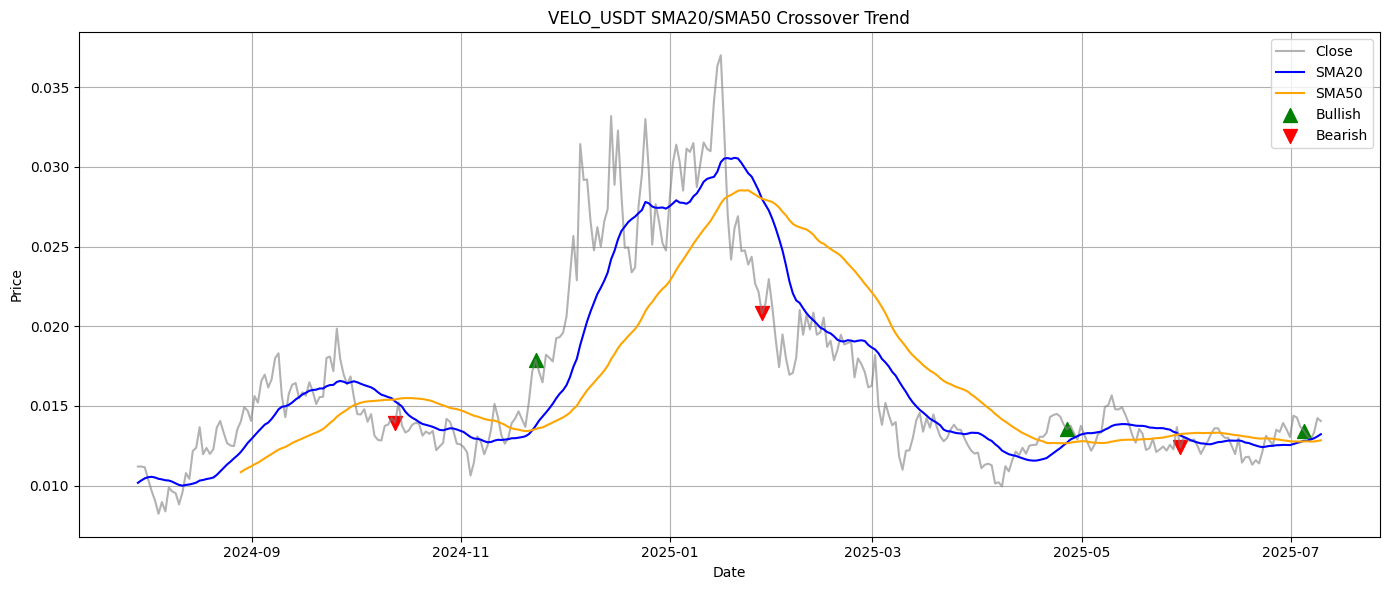

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

# 🔑 Connect to your local PostgreSQL DB
conn = psycopg2.connect(
    dbname="crypto_index",
    user="postgres",
    password="postgres",  
    host="localhost",
    port=5432
)
cur = conn.cursor()

# 📌 Set your token (start with VELO_USDT)
token = 'VELO_USDT'
# Step 1: Pull and pivot SMA data into wide format
sma_df = pd.read_sql(f"""
    SELECT token, timestamp, sma_window, sma_value
    FROM sma_data
    WHERE token = '{token}' AND sma_window IN (20, 50)
""", conn)

# Pivot from long to wide format: one row per timestamp, with sma20 and sma50 columns
sma_wide = sma_df.pivot(index='timestamp', columns='sma_window', values='sma_value').reset_index()
sma_wide.columns.name = None  # Remove pandas hierarchy on column names
sma_wide = sma_wide.rename(columns={20: 'sma20', 50: 'sma50'})

# Step 2: Get closing prices from ohlcv_data
close_df = pd.read_sql(f"""
    SELECT timestamp, close
    FROM ohlcv_data
    WHERE token = '{token}'
""", conn)

# Merge SMA and close price
price_df = pd.merge(close_df, sma_wide, on='timestamp', how='inner')

# Step 3: Load crossover signals
signal_df = pd.read_sql(f"""
    SELECT timestamp, signal
    FROM sma_signals
    WHERE token = '{token}'
""", conn)

# Merge signals into main dataframe
price_df['signal'] = None
for _, row in signal_df.iterrows():
    price_df.loc[price_df['timestamp'] == row['timestamp'], 'signal'] = row['signal']

# Step 4: Plot the trend chart
plt.figure(figsize=(14, 6))
plt.plot(price_df['timestamp'], price_df['close'], label='Close', alpha=0.6, color='gray')
plt.plot(price_df['timestamp'], price_df['sma20'], label='SMA20', color='blue')
plt.plot(price_df['timestamp'], price_df['sma50'], label='SMA50', color='orange')

buy = price_df[price_df['signal'] == 'bullish_crossover']
sell = price_df[price_df['signal'] == 'bearish_crossover']

plt.scatter(buy['timestamp'], buy['close'], marker='^', color='green', label='Bullish', s=100)
plt.scatter(sell['timestamp'], sell['close'], marker='v', color='red', label='Bearish', s=100)

plt.title(f"{token} SMA20/SMA50 Crossover Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
